<a href="https://colab.research.google.com/github/gitmurphy/breast-cancer-cnn-analysis/blob/main/mnv2_implementation_weightedrandomsampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Google Cloud Storage for access to the dataset and Dataflux for improved data transfer speeds
!pip install google-cloud-storage gcs-torch-dataflux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import libraries and dependencies
import os
import pandas as pd
import cv2
import numpy as np
from google.cloud import storage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from dataflux_pytorch import dataflux_mapstyle_dataset
from dataflux_core.download import download_single, DataFluxDownloadOptimizationParams, dataflux_download
from dataflux_core import fast_list
from io import BytesIO
from PIL import Image
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch import nn
import torch
import torch.optim as optim
from tqdm import tqdm
import datetime
from google.colab import drive, files
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


In [ ]:
# Setup Google Cloud Storage bucket - enusre to choose file from local system when prompted!
def setup_gcs():
    # Upload key file
    uploaded = files.upload()

    # Set key path
    key_path = "/content/my-gcs-key.json" # Replace with path to your key
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_path

    # Connect to bucket
    client = storage.Client()
    bucket = client.bucket('vindr-mammo-dataset')

    return bucket

bucket = setup_gcs()

Saving my-gcs-key.json to my-gcs-key.json


In [ ]:
"""
Set the device to GPU if available, otherwise CPU
Please note that the DataLoaders in this notebook have been optimized for use with Nvidias A100 GPU.
This is a high performance GPU but made accessible with a Google Colab Pro account.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# To ensure reproducibility set random seed
torch.manual_seed(42)

In [ ]:
# Define data augmentations
# These are applied in the transform method during dataset initialization
def get_augmentations():
    return [
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
    ]

In [ ]:
# Convert image to 8-bit (0-255) range
def normalize_int8(image: np.array):
    return cv2.normalize(
        image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F
    ).astype(np.uint8)

# Enhance contrast using CLAHE
def clahe(img, clip=1.5):
    clahe = cv2.createCLAHE(clipLimit=clip)
    return clahe.apply(img)

# Normalize image intensities within breast region
def truncate_normalization(image_mask: tuple):
    img, mask = image_mask
    Pmin = np.percentile(img[mask != 0], 2)
    Pmax = np.percentile(img[mask != 0], 99)
    truncated = np.clip(img, Pmin, Pmax)
    normalized = (truncated - Pmin) / (Pmax - Pmin) if Pmax != Pmin else np.zeros_like(truncated)
    normalized[mask == 0] = 0
    return normalized

# Crop to breast region using Otsu thresholding
def crop_to_roi(image: np.array):
    enhanced = clahe(image.copy(), 1.0)
    _, mask = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x, y, w, h = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    return image[y:y+h, x:x+w], mask[y:y+h, x:x+w]

In [ ]:
class VindrMammoDataset(Dataset):
    def __init__(self, bucket, split='training', transform=None):
        self.bucket = bucket
        self.split = split
        self.transform = transform or transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(0, 1),
            *get_augmentations()
        ])

        csv_blob = self.bucket.blob("finding_annotations.csv")
        csv_data = csv_blob.download_as_text()
        annotations_df = pd.read_csv(BytesIO(csv_data.encode()))

        df = annotations_df[annotations_df['split'] == self.split]
        df = df[['image_id', 'breast_birads']].reset_index(drop=True)
        df['label'] = df['breast_birads'].apply(self.birads_to_binary)
        self.df = df[['image_id', 'label']]
        self.labels = df['label'].values

    def birads_to_binary(self, value):
        try:
            num = int(value.split()[-1])
            return 0 if num <= 2 else 1
        except Exception as e:
            print(f"Error parsing BI-RADS value: {value} | Exception: {e}")
            return None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id, label = self.df.iloc[idx]
        img_path = f"images/{image_id}.png"
        blob = self.bucket.blob(img_path)
        image_data = blob.download_as_bytes()
        image = Image.open(BytesIO(image_data)).convert('L')
        cropped_image = crop_to_roi(np.array(image))[0]
        image = truncate_normalization((cropped_image, crop_to_roi(np.array(image))[1]))
        image = Image.fromarray(normalize_int8(image))
        image = self.transform(image)
        return image, label

In [ ]:
# Initialize the Data Loaders
train_dataset = VindrMammoDataset(bucket, split = 'training')
val_dataset = VindrMammoDataset(bucket, split = 'test')

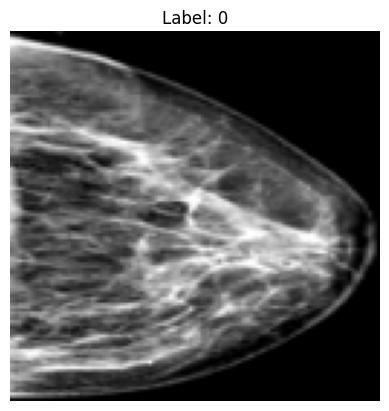

In [ ]:
# Visualize and manually inspect the images
image, label = train_dataset[4500] # Change index to view different images

plt.imshow(image[0], cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [ ]:
# Create the WeightedRandomSampler
class_counts = torch.bincount(torch.tensor(train_dataset.labels, dtype=torch.long))
class_weights = 1.0 / class_counts.float()
sample_weights = class_weights[train_dataset.labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [ ]:
# Create the DataLoaders (!Note that these are optimized for A100 - very large batch sizes.)
# Training DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=128, # for A100
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2 # Prefetch batches for optimum efficiency
)

# Validation DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    pin_memory=True,
    num_workers=4
)

In [ ]:
def build_model():
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)  # Use standard ImageNet pre-trained weights for MobileNetV2
    model.classifier[1] = nn.Linear(1280, 1)
    # Single output for binary classification

    return model
build_model()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Initalize the model and move to device
model = build_model()
model.to(device); # GPU or CPU as decided at the start

# Initialize weighted binary cross-entropy loss function
class_counts = torch.bincount(torch.tensor(train_dataset.labels, dtype=torch.long))
pos_weight = torch.tensor([class_counts[0] / class_counts[1]])  # Weight for positive class
pos_weight = pos_weight.to(device)
#criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss() # standard Binary Cross-Entropy Loss without any class weighting

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4) # Sweet spot from multiple test runs

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Train"):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation after each epoch
        val_loss = evaluate_model(model, val_loader, criterion, return_loss=True)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def evaluate_model(model, data_loader, criterion=None, return_loss=False):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if return_loss:
                total_loss += criterion(outputs, labels.float().unsqueeze(1)).item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if return_loss:
        return total_loss / len(data_loader)
    return np.array(all_preds), np.array(all_labels)

def calculate_accuracy(model, data_loader):
    preds, labels = evaluate_model(model, data_loader)
    accuracy = 100 * (preds == labels).mean()
    print(f'Model Accuracy: {accuracy:.2f}%')
    return accuracy

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, data_loader):
    preds, labels = evaluate_model(model, data_loader)
    cm = confusion_matrix(labels, preds)

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create labels
    annot_labels = np.array([
        [f"{count}\n({percent:.1f}%)" for count, percent in zip(row, percent_row)]
        for row, percent_row in zip(cm, cm_percent)
    ])

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=annot_labels,
        fmt="",
        cmap="Blues",
        xticklabels=["Benign", "Malignant"],
        yticklabels=["Benign", "Malignant"]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Counts with Percentages)')
    plt.show()

# Print precision, recall, and F1-score
def print_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).long().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\nClassification Metrics:")
    print(f"Precision: {precision:.4f}")  # TP / (TP + FP)
    print(f"Recall:    {recall:.4f}")     # TP / (TP + FN)
    print(f"F1-score:  {f1:.4f}")         # Mean of precision and recall

# Save the model after training because it will be lost once the colab runtime has ended
# Note - it wil be saved to the content folder of this runtime and should be downloaded manually from there
def save_model(model, prefix="model"):
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    path = f"{prefix}_{timestamp}.pth"
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
    return path

# Release variable from the GPU to avoid unnecessary cost
def cleanup():
    torch.cuda.empty_cache()

Epoch 1/5 Train: 100%|██████████| 129/129 [03:54<00:00,  1.82s/it]


Epoch 1/5 — Train Loss: 0.6069 | Val Loss: 0.5852


Epoch 2/5 Train: 100%|██████████| 129/129 [03:20<00:00,  1.56s/it]


Epoch 2/5 — Train Loss: 0.5170 | Val Loss: 0.5855


Epoch 3/5 Train: 100%|██████████| 129/129 [02:49<00:00,  1.31s/it]


Epoch 3/5 — Train Loss: 0.4473 | Val Loss: 0.5202


Epoch 4/5 Train: 100%|██████████| 129/129 [02:41<00:00,  1.25s/it]


Epoch 4/5 — Train Loss: 0.3670 | Val Loss: 0.5158


Epoch 5/5 Train: 100%|██████████| 129/129 [02:44<00:00,  1.28s/it]


Epoch 5/5 — Train Loss: 0.3365 | Val Loss: 0.5526


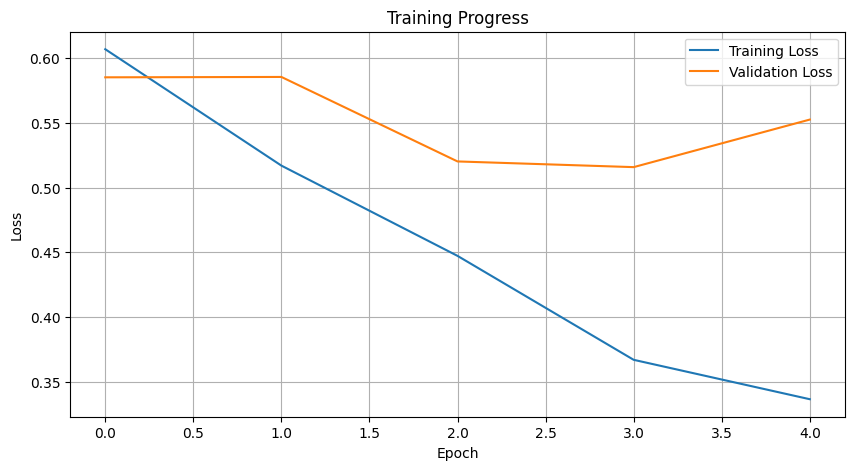

Model Accuracy: 77.66%


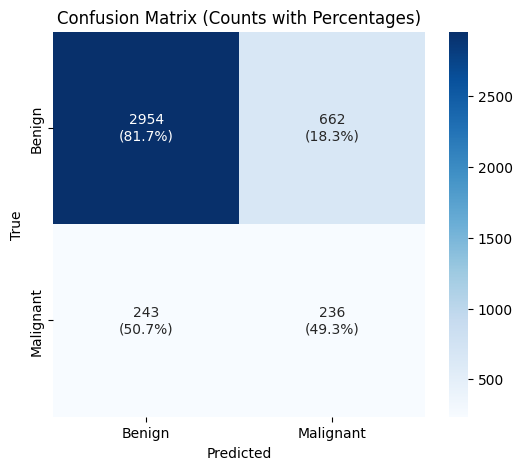


Classification Metrics:
Precision: 0.2632
Recall:    0.4781
F1-score:  0.3395
Model saved to mnv2-weightedrandomsampler-only_20250427_163345.pth


In [ ]:
# Training step
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

# Evaluation steps
plot_losses(train_losses, val_losses)
calculate_accuracy(model, val_loader)
plot_confusion_matrix(model, val_loader)
print_metrics(model, val_loader)

# Final steps
save_model(model, "mnv2-weightedrandomsampler-only")
cleanup()